# Evaluator Module
The Evaluator module creates evaluation reports.

Reports contain evaluation metrics depending on models specified in the evaluation config.

In [1]:
from collections import defaultdict
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, LeaveOneOut

from configs import EvalConfig
from constants import Constant as C
import constants as C  # If both are needed for different usages
from loaders import load_ratings, load_items, export_evaluation_report
from models import get_top_n


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Model validation functions
Validation functions are a way to perform crossvalidation on recommender system models. 

In [2]:
from constants import Constant as C

def load_ratings(surprise_format=False):
    df_ratings = pd.read_csv(C.EVIDENCE_PATH/ C.RATINGS_FILENAME)
    if surprise_format:
        reader = Reader(rating_scale=C.RATINGS_SCALE)
        data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
        return data
    else:
        return df_ratings

def generate_split_predictions(algo, ratings_dataset, eval_config):
    """
    Generate predictions on a random test set specified in eval_config.
    
    Parameters:
        algo: A Surprise algorithm instance (e.g., SVD, KNNBasic).
        ratings_dataset: A Surprise Dataset object.
        eval_config: An EvalConfig object containing evaluation parameters (e.g., test_size).
    
    Returns:
        List of predictions made by the algorithm on the test set.
    """
    # Récupérer la proportion test depuis eval_config
    test_size = eval_config.test_size
    # Diviser le dataset en train/test
    trainset, testset = train_test_split(ratings_dataset, test_size=test_size)
    # Entraîner le modèle sur le trainset
    algo.fit(trainset)
    # Faire des prédictions sur le testset
    predictions = algo.test(testset)
    return predictions


def generate_loo_top_n(algo, ratings_dataset, eval_config):
    #Generate top-n recommendations for each user on a random Leave-one-out split (LOO)
    #leaveOneOut object with one split
    loo = LeaveOneOut(n_splits=1)
    # Split the dataset into training and testing sets
    trainset, testset = next(loo.split(ratings_dataset))
    # Train the algorithm on the training set
    algo.fit(trainset)
    # Generate the anti-testset
    anti_testset = trainset.build_anti_testset()
    # Generate predictions on the anti-testset
    predictions = algo.test(anti_testset)
    # Get top-N recommendations
    anti_testset_top_n = get_top_n(predictions, n=eval_config.top_n_value)
    return anti_testset_top_n, testset


def generate_full_top_n(algo, ratings_dataset, eval_config):
    #Generate top-n recommendations for each user with full training set (LOO)
    # Construire l’ensemble d’entraînement complet à partir de toutes les données
    full_trainset = ratings_dataset.build_full_trainset()

    # Entraîner l’algorithme sur toutes les données disponibles
    algo.fit(full_trainset)

    # Générer le anti-testset : tous les items que chaque utilisateur n’a pas encore notés
    anti_testset = full_trainset.build_anti_testset()

    # Générer les prédictions sur le anti-testset
    predictions = algo.test(anti_testset)

    # Extraire les top-N recommandations
    anti_testset_top_n = get_top_n(predictions, n=eval_config.top_n_value)

    return anti_testset_top_n 

def precompute_information():
    """Returns a dictionary that precomputes relevant information for evaluating in full mode
    and for initializing ContentBased models with pre-computed features and scalers.

    Dictionary keys:
    - precomputed_dict["item_to_rank"] : contains a dictionary mapping movie ids to rankings (from original code)
    - precomputed_dict["feature_stats"] : dictionary of min/max values for numeric features
    - precomputed_dict["tfidf_vectorizers"] : dictionary of pre-fitted TfidfVectorizer objects
    - precomputed_dict["one_hot_columns"] : dictionary of column names for one-hot encoded features
    """

    ratings = load_ratings()
    items = load_items() # Charger les items ici

    precomputed_dict = {}

    # --- 1. Informations existantes (popularité des films) ---
    item_counts = ratings['movieId'].value_counts().sort_values(ascending=False)
    precomputed_dict['item_to_rank'] = {movie: idx + 1 for idx, movie in enumerate(item_counts.index)}

    # --- 2. Précalcul des statistiques pour la normalisation des features numériques ---
    feature_stats = {}

    # title_length
    df_title_length = items[C.LABEL_COL].apply(lambda x: len(x)).to_frame('title_length')
    df_title_length['title_length'] = df_title_length['title_length'].fillna(0).astype(int)
    mean_title_length = int(df_title_length['title_length'].replace(0, np.nan).mean())
    feature_stats['title_length'] = {
        'min': df_title_length['title_length'].min(),
        'max': df_title_length['title_length'].max(),
        'mean_fillna': mean_title_length
    }

    # Year_of_release
    year = items[C.LABEL_COL].str.extract(r'\((\d{4})\)')[0].astype(float)
    df_year = year.to_frame(name='year_of_release')
    mean_year = df_year.replace(0, np.nan).mean().iloc[0]
    feature_stats['year_of_release'] = {
        'min': df_year['year_of_release'].min(),
        'max': df_year['year_of_release'].max(),
        'mean_fillna': mean_year
    }

    # average_ratings
    average_rating = ratings.groupby('movieId')[C.RATING_COL].mean().rename('average_rating').to_frame()
    global_avg_rating = ratings[C.RATING_COL].mean()
    feature_stats['average_rating'] = {
        'min': average_rating['average_rating'].min(),
        'max': average_rating['average_rating'].max(),
        'mean_fillna': global_avg_rating
    }

    # count_ratings
    rating_count = ratings.groupby('movieId')[C.RATING_COL].size().rename('rating_count').to_frame()
    rating_count['rating_count'] = rating_count['rating_count'].fillna(0).astype(int)
    mean_rating_count = int(rating_count['rating_count'].replace(0, np.nan).mean())
    feature_stats['count_ratings'] = {
        'min': rating_count['rating_count'].min(),
        'max': rating_count['rating_count'].max(),
        'mean_fillna': mean_rating_count
    }

    # TMDB features (vote_average, popularity, budget, revenue, runtime, vote_count, profit)
    tmdb_path = C.CONTENT_PATH / "tmdb_full_features.csv"
    df_tmdb = pd.read_csv(tmdb_path).drop_duplicates('movieId').set_index('movieId')

    for col in ['vote_average', 'popularity', 'budget', 'revenue', 'runtime', 'vote_count']:
        mean_val = df_tmdb[col].mean()
        feature_stats[f'tmdb_{col}'] = {
            'min': df_tmdb[col].min(),
            'max': df_tmdb[col].max(),
            'mean_fillna': mean_val
        }

    # Profit (dérivé du budget et revenue)
    df_tmdb['profit'] = df_tmdb['revenue'] - df_tmdb['budget']
    mean_profit = df_tmdb['profit'].mean()
    feature_stats['tmdb_profit'] = {
        'min': df_tmdb['profit'].min(),
        'max': df_tmdb['profit'].max(),
        'mean_fillna': mean_profit
    }
    
    precomputed_dict['feature_stats'] = feature_stats

    # --- 3. Pré-entraînement des TF-IDF Vectorizers ---
    tfidf_vectorizers = {}
    
    # Genre_tfidf
    items_copy = items.copy()
    items_copy['genre_string'] = items_copy[C.GENRES_COL].fillna('').str.replace('|', ' ', regex=False)
    tfidf_genre = TfidfVectorizer()
    tfidf_genre.fit(items_copy['genre_string'])
    tfidf_vectorizers['Genre_tfidf'] = tfidf_genre

    # Tags
    tags_path = C.CONTENT_PATH / "tags.csv"
    df_tags = pd.read_csv(tags_path)
    df_tags = df_tags.dropna(subset=['tag'])
    df_tags['tag'] = df_tags['tag'].astype(str)
    df_tags_grouped = df_tags.groupby('movieId')['tag'].agg(' '.join).to_frame('tags')
    tfidf_tags = TfidfVectorizer()
    tfidf_tags.fit(df_tags_grouped['tags'])
    tfidf_vectorizers['Tags'] = tfidf_tags

    # title_tfidf (avec lemmatisation et stopwords)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    items_copy['title_string_processed'] = items_copy[C.LABEL_COL].fillna('').apply(lambda x: ' '.join(
                                lemmatizer.lemmatize(word) for word in x.split() if word.lower() not in stop_words
                            ))
    tfidf_title = TfidfVectorizer()
    tfidf_title.fit(items_copy['title_string_processed'])
    tfidf_vectorizers['title_tfidf'] = tfidf_title

    # tmdb_cast
    df_tmdb_cast = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_cast['cast'] = df_tmdb_cast['cast'].fillna('')
    tfidf_cast = TfidfVectorizer()
    tfidf_cast.fit(df_tmdb_cast['cast'])
    tfidf_vectorizers['tmdb_cast'] = tfidf_cast

    # tmdb_director
    df_tmdb_director = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_director['director'] = df_tmdb_director['director'].fillna('')
    tfidf_director = TfidfVectorizer()
    tfidf_director.fit(df_tmdb_director['director'])
    tfidf_vectorizers['tmdb_director'] = tfidf_director

    precomputed_dict['tfidf_vectorizers'] = tfidf_vectorizers

    # --- 4. Colonnes pour One-Hot Encoding (pour garantir la cohérence des colonnes) ---
    one_hot_columns = {}

    # tmdb_original_language
    df_tmdb_lang = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_lang['original_language'] = df_tmdb_lang['original_language'].fillna('unknown')
    one_hot_columns['tmdb_original_language'] = pd.get_dummies(df_tmdb_lang['original_language'], prefix='lang').columns.tolist()
    
    precomputed_dict['one_hot_columns'] = one_hot_columns

    return precomputed_dict        


def create_evaluation_report(eval_config, sp_ratings, precomputed_dict, available_metrics):
    """ Create a DataFrame evaluating various models on metrics specified in an evaluation config.  
    """
    evaluation_dict = {}
    for model_name, model, arguments in eval_config.models:
        print(f'Handling model {model_name}')
        algo = model(**arguments)
        evaluation_dict[model_name] = {}
        
        # Type 1 : split evaluations
        if len(eval_config.split_metrics) > 0:
            print('Training split predictions')
            predictions = generate_split_predictions(algo, sp_ratings, eval_config)
            for metric in eval_config.split_metrics:
                print(f'- computing metric {metric}')
                assert metric in available_metrics['split']
                evaluation_function, parameters =  available_metrics["split"][metric]
                evaluation_dict[model_name][metric] = evaluation_function(predictions, **parameters) 

        # Type 2 : loo evaluations
        if len(eval_config.loo_metrics) > 0:
            print('Training loo predictions')
            anti_testset_top_n, testset = generate_loo_top_n(algo, sp_ratings, eval_config)
            for metric in eval_config.loo_metrics:
                assert metric in available_metrics['loo']
                evaluation_function, parameters =  available_metrics["loo"][metric]
                evaluation_dict[model_name][metric] = evaluation_function(anti_testset_top_n, testset, **parameters)
        
        # Type 3 : full evaluations
        if len(eval_config.full_metrics) > 0:
            print('Training full predictions')
            anti_testset_top_n = generate_full_top_n(algo, sp_ratings, eval_config)
            for metric in eval_config.full_metrics:
                assert metric in available_metrics['full']
                evaluation_function, parameters = available_metrics["full"][metric]
            #    Pour novelty, passer item_to_rank comme argument
                if metric == "novelty":
                    evaluation_dict[model_name][metric] = evaluation_function(
                    anti_testset_top_n,
                    item_to_rank=precomputed_dict["item_to_rank"],
                    **parameters
                    )
                else:
                    evaluation_dict[model_name][metric] = evaluation_function(
                    anti_testset_top_n,
                    **parameters
                    )
    return pd.DataFrame.from_dict(evaluation_dict).T 


# 2. Evaluation metrics
Implement evaluation metrics for either rating predictions (split metrics) or for top-n recommendations (loo metric, full metric)

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_hit_rate(anti_testset_top_n, testset):
    """Compute the average hit over the users (loo metric)
    
    A hit (1) happens when the movie in the testset has been picked by the top-n recommender
    A fail (0) happens when the movie in the testset has not been picked by the top-n recommender"""
    
   #implement the function get_hit_rate 
    hits = 0
    total = len(testset)  

    # Iterate through each entry in the testset
    for user_id, movie_id, _ in testset:
        top_n_recommendations = anti_testset_top_n.get(user_id, [])
        if movie_id in [recommended_movie[0] for recommended_movie in top_n_recommendations]:
            hits += 1 

    hit_rate = hits / total if total > 0 else 0
    return hit_rate


def get_novelty(anti_testset_top_n, item_to_rank):
    """Compute the average novelty of the top-n recommendation over the users (full metric)
    
    The novelty is defined as the average ranking of the movies recommended
    """
    total_rank_sum = 0
    total_items = 0
    
    if item_to_rank is None:
        raise ValueError("item_to_rank cannot be None")

    for uid, user_recs in anti_testset_top_n.items():
        for iid, _ in user_recs:
            rank = item_to_rank.get(iid, None)
            if rank is not None:
                total_rank_sum += rank
                total_items += 1
 
    # Calculate the average novelty
    if total_items > 0:
        average_rank_sum = total_rank_sum / total_items
        normalized_average_rank_sum = (average_rank_sum - 1) / (len(item_to_rank) - 1)
    else:
        average_rank_sum = 0

    return normalized_average_rank_sum

def get_accuracy(predictions):
        """Compute the accuracy for rating predictions (split metric).
        Accuracy is defined as the proportion of predictions where the rounded predicted rating equals the true rating."""
        correct = 0
        total = len(predictions)
        for pred in predictions:
            if round(pred.est) == round(pred.r_ui):
                correct += 1
        return correct / total if total > 0 else 0

def get_precision(anti_testset_top_n, testset):
            """
            Compute the average precision over all users (loo metric).
            Precision is defined as the proportion of recommended items that are relevant (i.e., the test item is in the top-n recommendations).
            """
            hits = 0
            total_recommended = 0

            # Build a mapping from user to their test movie(s)
            test_movies = defaultdict(set)
            for user_id, movie_id, _ in testset:
                test_movies[user_id].add(movie_id)

            for user_id, recommendations in anti_testset_top_n.items():
                recommended_movies = set([movie_id for movie_id, _ in recommendations])
                relevant = test_movies.get(user_id, set())
                hits += len(recommended_movies & relevant)
                total_recommended += len(recommended_movies)

            precision = hits / total_recommended if total_recommended > 0 else 0
            return precision

def get_diversity(anti_testset_top_n):
    """
    Compute the average diversity of the top-n recommendations (full metric).
    Diversity is defined as the average pairwise dissimilarity between recommended items for each user.
    Here, we use the cosine distance between tag vectors as a proxy for dissimilarity.
    """

    # Load tags
    tags_df = pd.read_csv(r"C:\Users\mathi\OneDrive - UCL\Documents\GitHub\Recommender-Systeem-\mlsmm2156\data\tiny\content\tags.csv")
    # Aggregate tags per movie
    movie_tags = tags_df.groupby('movieId')['tag'].apply(lambda tags: ' '.join(str(tag) for tag in tags)).to_dict()

    # Build TF-IDF vectors for tags
    movie_ids = list(movie_tags.keys())
    tag_corpus = [movie_tags[mid] for mid in movie_ids]
    vectorizer = TfidfVectorizer()
    tag_matrix = vectorizer.fit_transform(tag_corpus)
    movieid_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

    def cosine_distance(vec1, vec2):
        if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
            return 0
        return 1 - np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    diversities = []
    for user_recommendations in anti_testset_top_n.values():
        rec_movie_ids = [movie_id for movie_id, _ in user_recommendations]
        if len(rec_movie_ids) < 2:
            continue
        pairwise_distances = []
        for i in range(len(rec_movie_ids)):
            for j in range(i + 1, len(rec_movie_ids)):
                idx1 = movieid_to_idx.get(rec_movie_ids[i])
                idx2 = movieid_to_idx.get(rec_movie_ids[j])
                if idx1 is not None and idx2 is not None:
                    vec1 = tag_matrix[idx1].toarray().flatten()
                    vec2 = tag_matrix[idx2].toarray().flatten()
                    pairwise_distances.append(cosine_distance(vec1, vec2))
        if pairwise_distances:
            diversities.append(np.mean(pairwise_distances))
    return np.mean(diversities) if diversities else 0



# 3. Evaluation workflow
Load data, evaluate models and save the experimental outcomes

In [4]:

AVAILABLE_METRICS = {
    "split": {
        "mae": (accuracy.mae, {'verbose': False}),
        "rmse": (accuracy.rmse, {'verbose': False}),
        "accuracy": (get_accuracy, {}),
    },
    "loo": {
        "hit_rate": (get_hit_rate, {}),
        "precision": (get_precision, {}),
    },
    "full": {
        "diversity" : (get_diversity, {}),
        "novelty": (get_novelty, {}),
    
     } 
}

sp_ratings = load_ratings(surprise_format=True)

precomputed_dict = precompute_information()
# afficher les informations pré-calculées
print("Informations pré-calculées :")
for key, value in precomputed_dict.items():
    print(f"{key}: {value}")

evaluation_report = create_evaluation_report(EvalConfig, sp_ratings, precomputed_dict, AVAILABLE_METRICS)
print("Résultats de l'évaluation des 4 modèles :")
display(evaluation_report)   
model_names = evaluation_report.index.tolist()
export_evaluation_report(evaluation_report, model_name= model_names)

Informations pré-calculées :
item_to_rank: {1240: 1, 1210: 2, 858: 3, 527: 4, 500: 5, 1208: 6, 590: 7, 1073: 8, 1968: 9, 2987: 10, 2011: 11, 34: 12, 6377: 13, 1225: 14, 923: 15, 5502: 16, 6333: 17, 2804: 18, 1219: 19, 4979: 20, 1092: 21, 5669: 22, 1250: 23, 899: 24, 2717: 25, 3499: 26, 1953: 27, 79132: 28, 49272: 29, 784: 30, 95: 31, 317: 32, 55820: 33, 1339: 34, 2006: 35, 3504: 36, 2746: 37, 4643: 38, 8622: 39, 6537: 40, 1345: 41, 708: 42, 509: 43, 8528: 44, 2724: 45, 3101: 46, 1032: 47, 1952: 48, 2881: 49, 5945: 50, 1172: 51, 673: 52, 2605: 53, 1095: 54, 5388: 55, 2427: 56, 3168: 57, 1212: 58, 2352: 59, 2953: 60, 2087: 61, 160: 62, 1299: 63, 3: 64, 91529: 65, 2942: 66, 1945: 67, 3450: 68, 515: 69, 1217: 70, 162: 71, 3362: 72, 1274: 73, 2501: 74, 535: 75, 494: 76, 3555: 77, 915: 78, 942: 79, 6323: 80, 2739: 81, 30749: 82, 37741: 83, 481: 84, 4105: 85, 2065: 86, 2805: 87, 4388: 88, 5064: 89, 2146: 90, 3146: 91, 44199: 92, 34319: 93, 3198: 94, 1779: 95, 2376: 96, 2642: 97, 3639: 98, 171

,mae,rmse,accuracy,hit_rate,precision,diversity,novelty
SVD_Classique_20,0.728244,0.946693,0.414653,0.345794,0.008645,0.984523,0.158433
SVD_Classique_40,0.705988,0.918932,0.422205,0.336449,0.008411,0.984756,0.197316
SVD_Classique_60,0.721447,0.920752,0.416163,0.186916,0.004673,0.983931,0.226615
SVD_Classique_80,0.742327,0.960033,0.403323,0.252336,0.006308,0.983139,0.239520
SVD_Classique_100,0.696997,0.899216,0.415408,0.168224,0.004206,0.983625,0.247231


Evaluation report successfully exported to: mlsmm2156\data\tiny\evaluations\evaluation_report_2025_06_12_4.csv


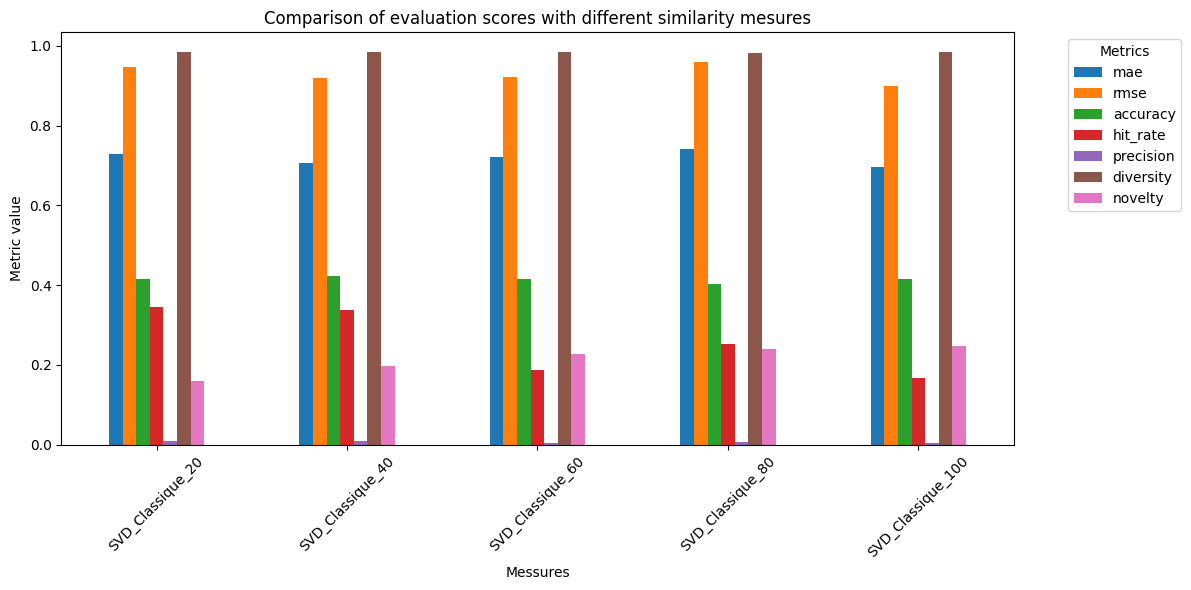

In [5]:
import pandas as pd
from constants import Constant as C
import os

import matplotlib.pyplot as plt

def plot_evaluation_comparison(evaluation_df=None):
    """
    Affiche un graphique comparatif des scores pour chaque modèle.
    Les noms des modèles sont affichés en abscisse, chaque métrique est représentée par une barre.
    Si evaluation_df n'est pas fourni, utilise la variable globale evaluation_report.
    """
    if evaluation_df is None:
        evaluation_df = evaluation_report

    ax = evaluation_df.plot(kind='bar', figsize=(12, 6))
    plt.title("Comparison of evaluation scores with different similarity mesures") 
    plt.ylabel("Metric value")
    plt.xlabel("Messures")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
plot_evaluation_comparison()

In [6]:
import matplotlib.pyplot as plt

def plot_mae_rmse_comparison(evaluation_df=None):
    """
    Affiche un graphique comparatif du MAE et du RMSE pour chaque modèle.
    Les noms des modèles sont affichés en abscisse, chaque métrique (MAE, RMSE) est représentée par une barre.
    Si evaluation_df n'est pas fourni, utilise la variable globale evaluation_report.
    """
    if evaluation_df is None:
        evaluation_df = evaluation_report

    metrics = ['mae', 'rmse']
    ax = evaluation_df[metrics].plot(kind='bar', figsize=(8, 5))
    plt.title("Comparison of MAE and RMSE for each model")
    plt.ylabel("Metric value")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
#plot_mae_rmse_comparison()

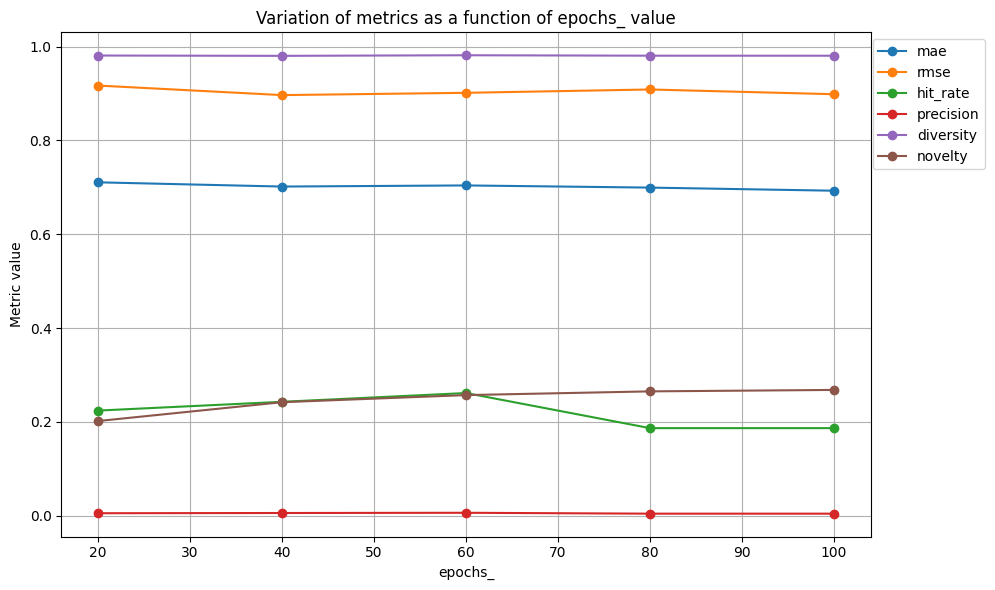

In [7]:
import pandas as pd
import os
import re
from configs import EvalConfig

import matplotlib.pyplot as plt

def plot_param_variation_metrics(eval_file=None, param_name="epochs_", param_pattern=None, metrics_to_exclude=None, model_prefix=None):
    """
    Compare la variation des métriques en fonction d'un paramètre arbitraire pour tous les modèles dont le nom contient une valeur correspondante.
    param_name: nom du paramètre à extraire (ex: "factors_", "k", "min_k", etc.).
    param_pattern: regex personnalisée pour extraire la valeur du paramètre depuis le nom du modèle (doit contenir un groupe de capture).
                   Si None, utilise des patterns courants selon le param_name.
    metrics_to_exclude: liste de noms de colonnes à exclure du tracé (ex: ["accuracy"]).
    model_prefix: si fourni, ne considère que les modèles dont le nom commence par ce préfixe (ex: "SVD_epochs_").
    Si eval_file est fourni, charge le DataFrame depuis ce fichier CSV dans le dossier evaluations.
    Sinon, utilise la variable globale evaluation_report.
    """
    # Charger le DataFrame depuis le fichier si fourni, sinon utiliser la variable globale
    if eval_file is not None:
        eval_path = os.path.join(C.EVALUATION_PATH, eval_file)
        df = pd.read_csv(eval_path)
        if 'name' in df.columns:
            df = df.set_index('name')
    else:
        df = evaluation_report.copy()

    # Filtrer selon le préfixe du modèle si demandé
    if model_prefix is not None:
        df = df[df.index.str.startswith(model_prefix)]

    # Définir le pattern de recherche selon le paramètre si non fourni
    if param_pattern is None:
        if param_name == "epochs_":
            param_pattern = r'epochs_(\d+)'
        elif param_name == "ridge_alpha":
            param_pattern = r'_ridge_([0-9.]+)$'
        elif param_name == "k":
            param_pattern = r'_k(\d+)'
        elif param_name == "min_k":
            param_pattern = r'_min_k(\d+)'
        else:
            # Par défaut, cherche _paramname(valeur) ou _paramname_valeur
            param_pattern = rf'_{param_name}[_()]([0-9.]+)'

    # Fonction pour extraire la valeur du paramètre depuis le nom du modèle
    def extract_param(model_name):
        match = re.search(param_pattern, model_name)
        if match:
            try:
                val = match.group(1)
                return float(val) if '.' in val else int(val)
            except Exception:
                return None
        # Sinon, essayer de trouver dans une colonne de paramètres si elle existe
        if param_name in df.columns:
            try:
                return float(df.loc[model_name, param_name])
            except Exception:
                return None
        return None

    # Ajouter une colonne temporaire avec la valeur extraite
    df["_param_value_tmp"] = df.index.map(extract_param)
    # Garder uniquement les modèles pour lesquels la valeur a été trouvée
    df = df[df["_param_value_tmp"].notnull()]
    df = df.sort_values("_param_value_tmp")

    # Déterminer les métriques à tracer (on exclut la colonne temporaire du paramètre)
    if metrics_to_exclude is None:
        metrics_to_exclude = ["index", param_name, "accuracy"]
    metrics_to_exclude = set(metrics_to_exclude) | {"_param_value_tmp"}
    metrics = [col for col in df.columns if col not in metrics_to_exclude and col != "_param_value_tmp"]

    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.plot(df["_param_value_tmp"], df[metric], marker='o', label=metric)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Metric value")
    plt.title(f"Variation of metrics as a function of {param_name} value")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
plot_param_variation_metrics(eval_file="evaluation_report_2025_06_03_5.csv", param_name="epochs_", metrics_to_exclude=["accuracy"])


In [ ]:
import os
import pandas as pd

def get_top_models_from_evaluation(metric, top_n=3, evaluations_dir=None, eval_file=None, asc=None):
    """
    Retourne les noms des modèles ayant les meilleurs scores pour une métrique donnée
    à partir d'un fichier d'évaluation dans le dossier 'evaluations'.

    Args:
        metric (str): Le nom de la métrique (ex: 'mae', 'rmse', 'accuracy', etc.).
        top_n (int): Le nombre de modèles à retourner.
        evaluations_dir (str, optional): Chemin du dossier contenant les fichiers d'évaluation.
        eval_file (str, optional): Nom du fichier d'évaluation à utiliser (sinon, prend le plus récent).
        asc (bool, optional): True pour les plus faibles valeurs, False pour les plus hautes valeurs.
                              Si None, utilise le comportement par défaut selon la métrique.

    Returns:
        list: Liste des noms de modèles avec les meilleurs scores pour la métrique choisie.
    """
    # Par défaut, utiliser le dossier défini dans la constante C
    if evaluations_dir is None:
        evaluations_dir = C.EVALUATION_PATH

    # Trouver le fichier d'évaluation à utiliser
    if eval_file is None:
        eval_files = [f for f in os.listdir(evaluations_dir) if f.endswith('.csv')]
        if not eval_files:
            raise FileNotFoundError("Aucun fichier d'évaluation trouvé dans le dossier spécifié.")
        eval_files = sorted(eval_files, key=lambda f: os.path.getmtime(os.path.join(evaluations_dir, f)), reverse=True)
        eval_file = eval_files[0]
    eval_path = os.path.join(evaluations_dir, eval_file)

    # Charger le DataFrame
    df = pd.read_csv(eval_path)
    if 'name' in df.columns:
        df = df.set_index('name')

    if metric not in df.columns:
        raise ValueError(f"La métrique '{metric}' n'existe pas dans le fichier d'évaluation.")

    # Pour les métriques où un score plus élevé est meilleur
    higher_is_better = ['accuracy', 'hit_rate', 'precision', 'diversity', 'novelty']
    if asc is None:
        ascending = metric not in higher_is_better
    else:
        ascending = asc

    # Trier et sélectionner les meilleurs modèles
    top_models = df.sort_values(metric, ascending=ascending).head(top_n)
    return list(top_models.index)

# Exemple d'utilisation :
# top_models = get_top_models_from_evaluation('accuracy', top_n=5)


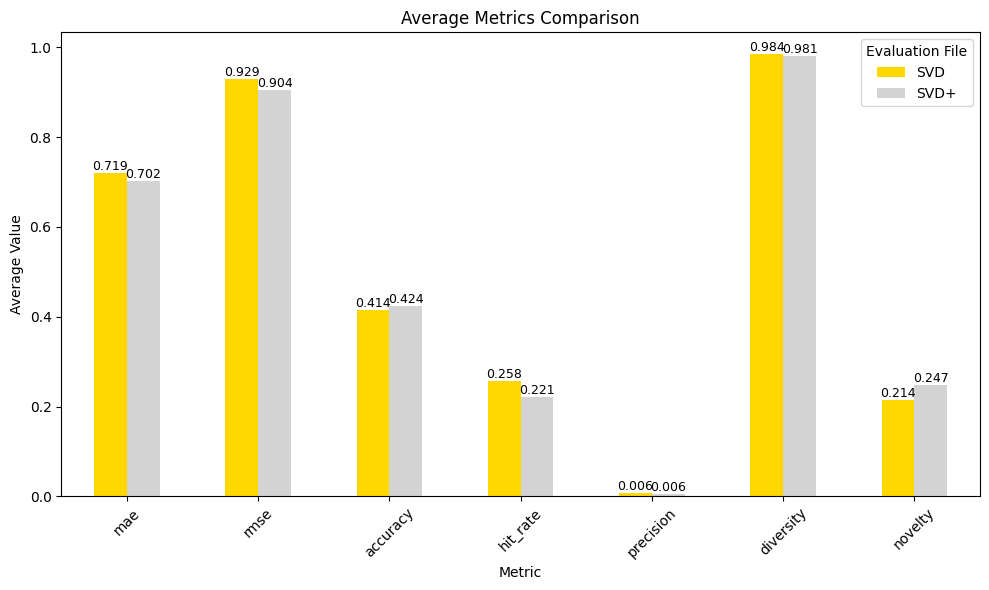

In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def plot_average_metrics_comparison(file1, file2, evaluations_dir=None):
    """
    Compute and plot the average of each metric from two evaluation CSV files,
    displaying values above bars and using yellow and gray colors.
    """
    if evaluations_dir is None:
        evaluations_dir = C.EVALUATION_PATH

    # Load the two CSV files
    path1 = os.path.join(evaluations_dir, file1)
    path2 = os.path.join(evaluations_dir, file2)
    df1 = pd.read_csv(path1, index_col=0)
    df2 = pd.read_csv(path2, index_col=0)

    # Keep only numeric columns
    metrics = [col for col in df1.columns if df1[col].dtype != 'O']

    # Compute averages
    avg1 = df1[metrics].mean()
    avg2 = df2[metrics].mean()

    # Create DataFrame for comparison
    avg_df = pd.DataFrame({
        "SVD": avg1,
        "SVD+": avg2
    })

    colors = ['gold', 'lightgray']
    ax = avg_df.plot(kind='bar', figsize=(10, 6), color=colors)
    plt.title("Average Metrics Comparison")
    plt.ylabel("Average Value")
    plt.xlabel("Metric")
    plt.xticks(rotation=45)
    plt.legend(title="Evaluation File")

    # Add values above bars
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.3f}', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black', rotation=0)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_average_metrics_comparison("evaluation_report_2025_06_12_4.csv", "evaluation_report_2025_06_03_5.csv")